# Imports

In [3]:
%pylab inline
%load_ext autoreload
%autoreload 2

import pandas as pd

# from matplotlib.colors import Lognorm
from scipy.integrate import simps
from time import time
import warnings
warnings.simplefilter("ignore")

Populating the interactive namespace from numpy and matplotlib


In [4]:
from ipywidgets import interact
import seaborn as sns
sns.set(palette='colorblind', style='whitegrid')
sns.set_style({'font.family': ['serif']})
from matplotlib.colors import LogNorm, SymLogNorm

In [5]:
from scipy.optimize import minimize
from scipy.interpolate import InterpolatedUnivariateSpline as ius
from scipy.interpolate import interp1d
from scipy import stats
from sklearn.metrics.pairwise import pairwise_kernels

from sklearn.gaussian_process import GaussianProcessRegressor as GPR
from sklearn.gaussian_process import kernels
RBF = kernels.RBF
WhiteKernel = kernels.WhiteKernel

In [6]:
sys.path.append('../cf_analysis/')
import tools

import glearn
from rscm import RSCM
import pcalearn
from sklearn.decomposition import PCA
from svdanalysis import SVDlearn
import synth


import kde
from sklearn.metrics.pairwise import pairwise_kernels
from sklearn.base import BaseEstimator, RegressorMixin
KernelRegression = kde.KernelRegression

import yjtransform as yjt


# Setup

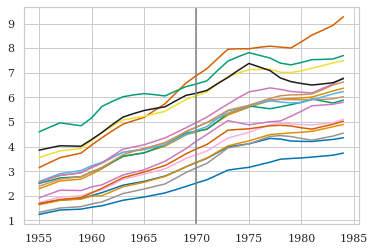

In [7]:
# data = pd.read_csv('The_Tax_Burden_on_Tobacco__1970-2017.csv')
# sales = data[data['SubMeasureDesc'] == 'Cigarette Consumption (Pack Sales Per Capita)']
# costs = data[data['SubMeasureDesc'] == 'Average Cost per pack ']    
# statesid = data['LocationAbbr'].unique()
# statesales, statecosts = {}, {}
# for ss in statesid:
#     statesales[ss] = sales[sales['LocationAbbr'] == ss]['Data_Value'].values.astype('float64')
#     statecosts[ss] = costs[costs['LocationAbbr'] == ss]['Data_Value'].values.astype('float64')


# Xraw = np.array([statesales[i] for i in statesales.keys()])
# Xraw -= Xraw.mean(axis=0)
# pcad = PCA(ncd).fit(Xraw)
# X = pcad.inverse_transform(pcad.transform(Xraw))
# N, T = X.shape[0], X.shape[1]
# T0 = 20
# t = np.arange(T)
    
    
data = pd.read_csv('../basque.csv')
years = data['year'].unique()
T0 = np.where(years == 1970)[0][0]
years = years[:2*T0]
gdp = data['gdpcap'].values.reshape(18, -1)
gdp = gdp[1:, :2*T0]
treated = gdp[-2]
rr = data['regionname'].unique()[-2]
controls = np.append(gdp[:-2], gdp[-1:], axis=0)

plt.plot(years, controls.T)
plt.plot(years, treated, 'k')
plt.axvline(1970, color='gray')
plt.show()

X = gdp.copy()
N, T = X.shape[0], X.shape[1]
t = np.arange(T)



In [8]:
   

# T = 100
# ncd = 10
# t = np.arange(0, T)
# T0 = 60
# N = 50


# X = np.random.normal(10, 2, N*T).reshape(N, T)
# X = X + np.random.normal(0, N, N).reshape(-1, 1)
# X = X + np.random.normal(np.arange(N)/2., N/4.).reshape(-1, 1).reshape(-1, 1)*t/T
# X = X + np.random.normal(np.arange(N)/2., N/4.).reshape(-1, 1)*t**2/T * np.exp(-2*t/T)
# # X = X + 1*np.random.normal(np.arange(N)/2., N/4.).reshape(-1, 1)* np.sin(np.pi/T* t* np.random.normal(size=N).reshape(-1, 1)) 
# X = X + 1*np.random.normal(np.arange(N)/2., N/4.).reshape(-1, 1)* np.sin(np.random.normal(0)*np.pi/T* t) 
# X = X + 1*np.random.normal(np.arange(N)/2., N/4.).reshape(-1, 1)* np.sin(np.random.normal(1)*np.pi/T* t) 
# X = X + 1*np.random.normal(np.arange(N)/2., N/4.).reshape(-1, 1)* np.sin(np.random.normal(2)*np.pi/T* t) 
# X = X + 1*np.random.normal(np.arange(N)/2., N/4.).reshape(-1, 1)* np.sin(np.random.normal(3)*np.pi/T* t) 
# X = X + 1*np.random.normal(np.arange(N)/2., N/4.).reshape(-1, 1)* np.sin(np.random.normal(4)*np.pi/T* t) 
# Xraw = X.copy()
# pcad = PCA(ncd).fit(Xraw)
# X = pcad.inverse_transform(pcad.transform(Xraw))

# itreated = np.random.randint(N)
# controls = np.concatenate([X[:itreated], X[itreated+1:]])
# treated = X[itreated]

# fig, ax = plt.subplots(1, 2, figsize = (8, 4))
# ax[0].plot(Xraw.T)
# ax[1].plot(controls.T, 'b', alpha=0.5)
# ax[1].plot(treated, 'r', alpha=1)
# plt.show()
# plt.plot(pcad.components_.T);
# plt.show()
# plt.plot(np.linalg.svd(Xraw)[1], 'o');
# plt.semilogy()
# plt.show()

# Fourier Anlaysis

In [9]:
# gl = glearn.GLearn(controls, padl=T, padr=T, stdscale=False)
# plt.plot(gl.pkraw, marker='.')
# plt.plot(gl.pkprior, marker='.')
# plt.loglog()

In [10]:
# glpred, glerr, glcov = gl.fit(treated, T0)

# bins = 30 
# normed = False
# # plt.hist((controls - means).flatten(), bins=bins, normed=normed, label='Data', alpha=0.6, color='C0')
# plt.hist((gl.controls-means).flatten(), bins=bins, normed=normed, label='Data', alpha=0.6, color='C0')
# plt.hist(gl.controlsg.flatten(), bins=bins, normed=normed, label='Transformed', alpha=0.6, color='C1')
# plt.legend()
# plt.show()
# # plt.hist(gca.controls.flatten())
# plt.plot(years, treated)
# plt.errorbar(years, glpred, glerr)
# plt.plot(years, means)

# Distribution of PCA components

In [11]:
xx = controls.copy()
means = xx.mean(axis=0)
yy = treated.copy()
xplot = np.arange(yy.size)

##
i = 0 
ncomp = tools.approximate_rank(xx-means , t=0.999)
# ncomp = tools.approximate_rank(xx - means, t=0.999)
# ncomp = 10
ncomp = 4
print(ncomp)
pcl = pcalearn.PCAlearn(xx, ncomp, stdscale=False, normalization='center')
pca = pcl.pca
errpca = pca.get_covariance().diagonal()**0.5


4


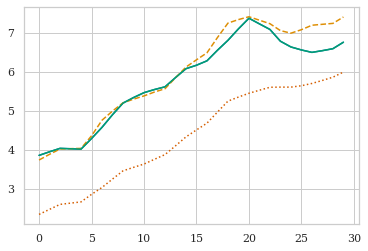

In [10]:

pclT0 = pcalearn.PCAlearn(xx[:, :T0], ncomp, stdscale=False, normalization='center')
pcaT0 = pclT0.pca

##
ypca, pp = pcl.fit(yy.flatten(), T0, regwt=None, verbose=True)
plt.plot(xplot, treated)
plt.plot(xplot, ypca, '--')
plt.plot(xplot, yy)
plt.plot(xplot, means, ':')
# plt.plot(xplot, ypcar, ":", lw=3, alpha=0.5)
# plt.plot(xplot, ypcar2, ':', lw=3, alpha=0.5)


In [11]:
pca

PCA(copy=True, iterated_power='auto', n_components=4, random_state=None,
    svd_solver='auto', tol=0.0, whiten=True)

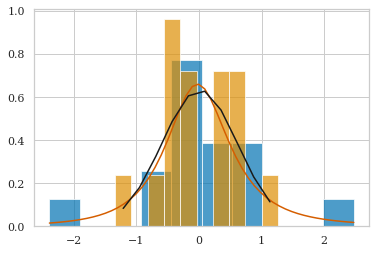

In [12]:
nbins=10
xxt = pca.transform(pcl.normalize(xx))
tt = xxt[:, 1].copy()
plt.hist(tt.flatten(), alpha=0.7, bins=nbins, density=True)
ptt = yjt.get_transform(tt)
# plt.plot(ttx, yjt.invtransform(ttx, ptt))
ttx = np.linspace(tt.min(), tt.max())
qq = yjt.getpdf(ttx, ptt)
plt.plot(ttx, qq, 'r')

y_, x_, _ = plt.hist(yjt.transform(tt,  ptt).flatten(), alpha=0.7, bins=nbins, density=True)
x_ = (x_[1:] + x_[:-1])/2.
pp = tools.fitgausspdf(yjt.transform(tt,  ptt).flatten(), normalized=True, verbose=0)    
plt.plot(x_, y_.max()*tools.logpdf_gauss(x_, *pp, rety=True), 'k')


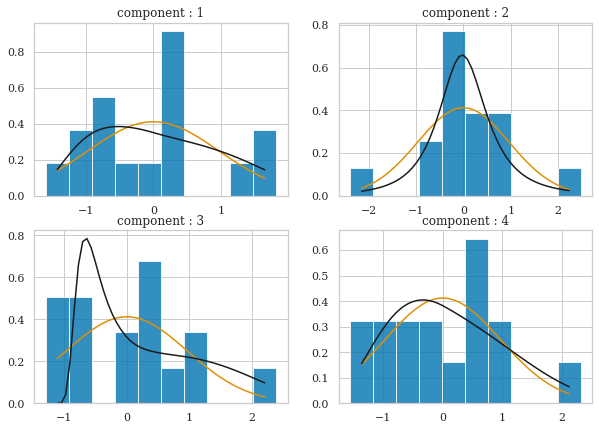

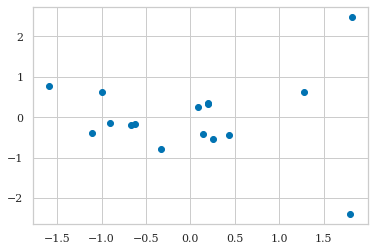

In [13]:
nbins = 10 
normed = True

# # ncomp = 10
# # xx = controls.copy()
# # pcl = pcalearn.PCAlearn(xx, ncomp, stdscale=False, normalization='center')
# # pca = pcl.pca
# xxt = pca.transform(pcl.normalize(xx))

fig, axar = plt.subplots(2, ncomp//2, figsize= (ncomp//2*5, 7))

ax = axar.flatten()
for ia in range(ncomp):
    if ia >= ax.size: break
    if ia > ncomp: break    
    y_, x_, _ = ax[ia].hist(xxt.T[ia], bins=nbins, density=normed, alpha=0.8)
    x_ = (x_[1:] + x_[:-1])/2.

    xplot = np.linspace(x_.min(), x_.max())
    ppg = tools.fitgausspdf(xxt.T[ia], normalized=True, verbose=0)    
    ax[ia].plot(xplot, tools.logpdf_gauss(xplot, *ppg, rety=True, normalized=True), 'C1')
    ax[ia].set_title("component : %d"%(ia+1))
    pyj = yjt.get_transform(xxt.T[ia])
    qq = yjt.getpdf(xplot, pyj)
    ax[ia].plot(xplot, qq, 'k')
    
plt.show()
plt.scatter(xxt[:, 0], xxt[:, 1])
plt.show()

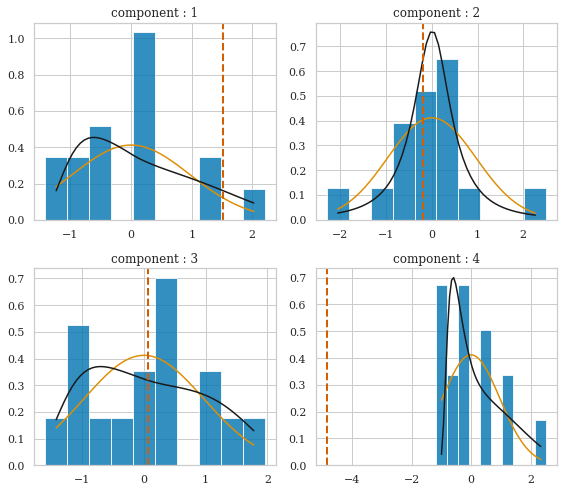

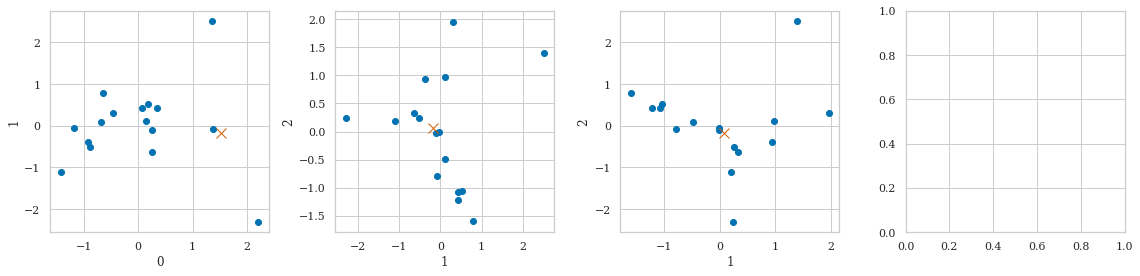

In [14]:
xxT0 = pcaT0.transform(pclT0.normalize(xx[:, :T0]))
ppT0 = pcaT0.transform(pclT0.normalize(treated[:T0]).reshape(1, -1))[0]

# fig, ax = plt.subplots(1, ncomp, figsize= (ncomp*4, 4))

# ppT0 = pcaT0.transform(treated[:T0].reshape(np.newaxis, 1))

fig, axar = plt.subplots(2, ncomp//2, figsize= (ncomp//2*4, 7))

ax = axar.flatten()
for ia in range(ncomp):
    if ia >= ax.size: break
    if ia > ncomp: break    
    y_, x_, _ = ax[ia].hist(xxT0.T[ia], bins=nbins, density=normed, alpha=0.8)
    x_ = (x_[1:] + x_[:-1])/2.

    xplot = np.linspace(x_.min(), x_.max())
    ppg = tools.fitgausspdf(xxT0.T[ia], normalized=True, verbose=0)    
    ax[ia].plot(xplot, tools.logpdf_gauss(xplot, *ppg, rety=True, normalized=True), 'C1')
    
    pyj = yjt.get_transform(xxT0.T[ia])
    qq = yjt.getpdf(xplot, pyj)
    ax[ia].plot(xplot, qq, 'k')
    
    ax[ia].axvline(ppT0[ia], color='r', lw=2, ls="--")
    ax[ia].set_title("component : %d"%(ia+1))

plt.tight_layout()
plt.show()

fig, ax = plt.subplots(1, ncomp, figsize= (ncomp*4, 4))
ax[0].scatter(xxT0[:, 0], xxT0[:, 1])
ax[0].plot(ppT0[0], ppT0[1], 'rx', markersize=10, lw=2)
ax[0].set_xlabel(0)
ax[0].set_ylabel(1)

ax[1].scatter(xxT0[:, 1], xxT0[:, 2])
ax[1].plot(ppT0[1], ppT0[2], 'rx', markersize=10)
ax[1].set_xlabel(1)
ax[1].set_ylabel(2)

ax[2].scatter(xxT0[:, 2], xxT0[:, 1])
ax[2].plot(ppT0[2], ppT0[1], 'rx', markersize=10, lw=2)
ax[2].set_ylabel(2)
ax[2].set_xlabel(1)
plt.tight_layout()
plt.show()

In [15]:
class PCAYJ():
    
    def __init__(self, controls, n_components, stdscale=False, seed=100, normalization='center', whiten=True):

        self.T = controls.shape[1]
        self.seed = seed
        self.controls = controls
        self.means = controls.mean(axis=0)
        if stdscale: self.stds = controls.mean(axis=0)
        else : self.stds = 1
        self.cmin, self.cmax = self.controls.min(), self.controls.max()
        self.normalization = normalization
        self.controls_norm = self.normalize(self.controls)
        
        self.n_components = n_components
        self.pca = PCA(n_components=self.n_components, whiten=whiten)
        self.pca.fit(self.normalize(self.controls))
        self.cov = self.pca.get_covariance()
        self.icov = self.pca.get_precision()
        
        self.control_wts = self.pca.transform(self.controls_norm)
        self.pyj = []
        for i in range(self.n_components): self.pyj.append(yjt.get_transform(self.control_wts[:, i]))
        
    def normalize(self, x):
        if self.normalization is None: return x
        if self.normalization == 'center': return  (x - self.means)/self.stds
        elif self.normalization == 'minmax' :
            off, norm = (self.cmax+self.cmin)/2., (self.cmax-self.cmin)/2.
            return (x-off)/norm

    def unnormalize(self, y):
        if self.normalization is None: return y
        if self.normalization == 'center': return y * self.stds + self.means
        elif self.normalization == 'minmax' :
            off, norm = (self.cmax+self.cmin)/2., (self.cmax-self.cmin)/2.
            return y*norm + off


    def fit(self, treated, ols=True, verbose=False, method='lbfgs',):

        yy = self.normalize(treated.copy())

        def _chisq(p):
            #yp = self.pca.inverse_transform(p)                                                                                                                                 
            yp = np.dot(self.pca.components_.T, p) + self.pca.mean_
            diff = yy-yp
            diff[T0:] = 0
            chisq = np.sum(diff**2)
#             chisq = np.dot(np.dot(diff, self.icov), diff)
            return chisq
        
        def _logprior(p):
            reg = 0 
            for i in range(self.n_components): reg += np.log(yjt.getpdf(np.array(p[i]), self.pyj[i]))
            return reg
        
        def _loss(p):
            return _chisq(p) - _logprior(p)

        p0 = np.zeros(self.n_components)
#         p0 = np.random.normal(size=self.n_components)
        
        if method == 'nelder-mead': pp = minimize(_loss, p0, method='Nelder-Mead', options={'maxiter':50000, 'maxfev':50000, 'tol':1e-10, 'rtol':1e-10})
        elif method == 'lbfgs' : pp = minimize(_loss, p0, method='L-BFGS-B', options={'maxiter':50000, 'ftol': 1e-10, 'gtol': 1e-8, 'eps': 1e-10, 'maxfun': 50000})
        if verbose == 1: print(pp.fun)
        if verbose > 1: print(pp)
        if verbose >=1 : print(_chisq(pp.x), _logprior(pp.x))
        pp = pp.x
        yp = np.dot(self.pca.components_.T, pp) + self.pca.mean_
        #yp = self.pca.inverse_transform(pp)                                                                                                                                        
        yp = self.unnormalize(yp)
        return yp, pp





In [16]:
pcayj = PCAYJ(controls, 5, whiten=False)
# ty, tp = pcayj.fit(treated, T0, verbose=2, method='nelder-mead')
ty, tp = pcayj.fit(treated, T0, verbose=2, method='lbfgs')

      fun: 41.7824241777502
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>
      jac: array([-7.90805643, -8.39172287,  5.5174354 ,  1.74850356,  3.78342691])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 18
      nit: 1
   status: 0
  success: True
        x: array([0., 0., 0., 0., 0.])
39.55089694575089 -2.231527231999312


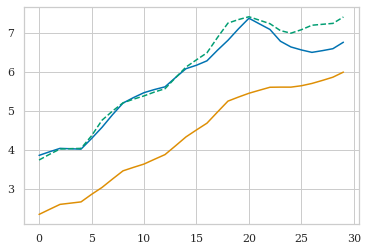

In [17]:
# plt.plot(means, 'gray')
plt.plot(treated)
plt.plot(ty)
plt.plot(ypca, '--')


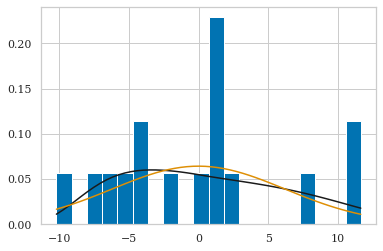

In [18]:
ii = 0
xdata = pcayj.control_wts[:, ii]
plt.hist(xdata, density=True, bins=20)
xplot = np.linspace( xdata.min(), xdata.max())
plt.plot(xplot, yjt.getpdf(xplot, pcayj.pyj[ii]), 'k')
ppg = tools.fitgausspdf(xdata)
plt.plot(xplot, tools.logpdf_gauss(xplot, *ppg, rety=True))
# plt.plot(xplot, yjt.getpdf(xplot, pcayj.pyj[ii]))

# KDE

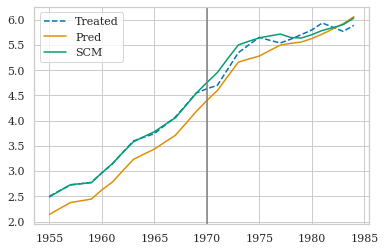

In [12]:
def get_ykde(gg, X1, X2, Y1, gamma=np.logspace(-3, 0, 1000), caty1=True):
    kde = KernelRegression(gg, gamma=gamma)
    kde.fit(X1, X2)
    if len(Y1.shape) <=1: Y1 =  Y1.reshape(1,-1)
    ykde, wts = kde.predict(Y1, retK=True)
    ykde0 = kde.predict(Y1, X1, retK=False)
    ykde = ykde.flatten()
    ykde0 = ykde0.flatten()
    if caty1 == 1: ykde = np.concatenate([Y1.flatten(), ykde])
    elif caty1 == 2: ykde = np.concatenate([ykde0, ykde]) 
    return ykde, kde, wts
 

ii = itreated
xxc = np.concatenate([X[:ii], X[ii+1:]])
yyc = X[ii]
means = xxc.mean(axis=0)*0
stds = xxc.std(axis=0)*0 + 1
xx = (xxc - means)/stds
yy = (yyc - means)/stds

##
X1 = xx[:, :T0]
X2 = xx[:, T0:]
Y1 = yy[:T0]
Y2 = yy[T0:]

#
yp, kde, wts = get_ykde('rbf', X1, X2, Y1, caty1=2)
print(kde.gamma)
yp *= stds
yp += means


plt.plot(years, yyc, '--', label='data')
plt.plot(years, yp, label='pred')
# plt.plot(years, means, 'k--', label='means')


nc1, nc2 = tools.approximate_rank(X1, 0.99), tools.approximate_rank(X2, 0.99)
if nc1 <=1 : nc1 +=1 
if nc2 <=1 : nc2 +=1 
print(nc1, nc2)
# nc1, nc2 = 3, 3 
p1, p2 = PCA(nc1, whiten=False).fit(X1), PCA(nc2, whiten=False).fit(X2)
XX1, XX2 = p1.transform(X1), p2.transform(X2)
YY1 = p1.transform(Y1.reshape(1,-1))
ykdep, kde, wts = get_ykde('rbf', XX1, XX2, YY1, caty1=2)
y1, y2 = ykdep[:nc1], ykdep[nc1:]
yp = np.concatenate([p1.inverse_transform(y1), p2.inverse_transform(y2)]) 
yp *= stds
yp += means
plt.plot(years, yp, label='pred-pc')

ypscm, wts = synth.fit(xx, yy, T0)
plt.plot(years, ypscm*stds + means, label='SCM')
plt.axvline(years[T0], color='gray')
plt.legend()

In [20]:
kde

KernelRegression(gamma=3.1296480106707505, kernel='rbf')

# PCA fits on controls states - a Placebo study

In [21]:
pc = PCA(3).fit(controls)
pcw = PCA(3,whiten=True).fit(controls)

pc.components_/ pcw.components_;
np.dot(pc.transform(controls).T, pc.transform(controls)), np.dot(pcw.transform(controls).T, pcw.transform(controls))

(array([[ 6.16417799e+02,  5.89750471e-13, -2.13162821e-14],
        [ 5.89750471e-13,  1.69124539e+01, -1.33781874e-14],
        [-2.13162821e-14, -1.33781874e-14,  1.01927294e+00]]),
 array([[ 1.50000000e+01,  8.70414851e-14, -1.33226763e-14],
        [ 8.70414851e-14,  1.50000000e+01, -4.82947016e-14],
        [-1.33226763e-14, -4.82947016e-14,  1.50000000e+01]]))

In [22]:
years = t
            
xplot = years.copy()            

class GetObject(object):
    def __init__(self, *initial_data, **kwargs):
        for dictionary in initial_data:
            for key in dictionary:
                setattr(self, key, dictionary[key])
        for key in kwargs:
            setattr(self, key, kwargs[key])


            
            
    
statesscm =  {}
for ii, ss in enumerate(np.arange(N)):
    xx = np.concatenate([X[:ii], X[ii+1:]])
    yy = X[ii]
    means = xx.mean(axis=0)
    ##
    ##
    X1 = (xx - means)[:, :T0]
    X2 = (xx - means)[:, T0:]
    Y1 = (yy-means)[:T0]
    Y2 = (yy-means)[T0:]
    yp, wts = synth.fit(xx, yy, T0)
        
    statesscm[ss] = GetObject(controls=xx, treated=yy, pred=yp, wts=wts)

In [23]:
ncpca = tools.approximate_rank(controls-means, t=0.99)
print("rank = ", ncpca)


statepcafits = {}


for ii, ss in enumerate(np.arange(N)):
    xx = np.concatenate([X[:ii], X[ii+1:]])
    yy = X[ii]
    means = xx.mean(axis=0)
    ##
    pcl = pcalearn.PCAlearn(xx, ncpca, stdscale=False, normalization='center')
    ##
    ypca2, pp2 = pcl.fit(yy.flatten(), T0, ols=True, regwt=None, verbose=False)
    statepcafits[ss] = GetObject(controls=xx, treated=yy, pred=ypca2, pcl=pcl, fitp=pp2)


statepcafitsyj = {}

for ii, ss in enumerate(np.arange(N)):
    xx = np.concatenate([X[:ii], X[ii+1:]])
    yy = X[ii]
    means = xx.mean(axis=0)
    ##
    pcl = PCAYJ(xx, ncpca, stdscale=False, normalization='center', whiten=False)
    ##
    ypca2, pp2 = pcl.fit(yy.flatten(), T0, method='nelder-mead')
    
    statepcafitsyj[ss] = GetObject(controls=xx, treated=yy, pred=ypca2, pcl=pcl, fitp=pp2)



rank =  2


In [24]:
ncpca3 = 3


statepcafits3 = {}

for ii, ss in enumerate(np.arange(N)):
    xx = np.concatenate([X[:ii], X[ii+1:]])
    yy = X[ii]
    means = xx.mean(axis=0)
    ##
    pcl = pcalearn.PCAlearn(xx, ncpca3, stdscale=False, normalization='center')
    ##
    ypca2, pp2 = pcl.fit(yy.flatten(), T0, ols=True, regwt=None, verbose=False)
    statepcafits3[ss] = GetObject(controls=xx, treated=yy, pred=ypca2, pcl=pcl, fitp=pp2)


statepcafitsyj3 = {}

for ii, ss in enumerate(np.arange(N)):
    xx = np.concatenate([X[:ii], X[ii+1:]])
    yy = X[ii]
    means = xx.mean(axis=0)
    ##
    ##
    pcl = PCAYJ(xx, ncpca3, stdscale=False, normalization='center', whiten=False)
    ##
    ypca2, pp2 = pcl.fit(yy.flatten(), T0, method='nelder-mead')    
    
    statepcafitsyj3[ss] = GetObject(controls=xx, treated=yy, pred=ypca2, pcl=pcl, fitp=pp2)



In [25]:
statesvdfitsc = {}

for ii, ss in enumerate(np.arange(N)):
    xx = np.concatenate([X[:ii], X[ii+1:]])
    yy = X[ii]
    means = xx.mean(axis=0)
    ##
    ##
    svl = SVDlearn(xx, stdscale=False, normalization='center')
    yp, pp = svl.fit(yy.flatten(), T0, ncpca, verbose=False)
    statesvdfitsc[ss] = GetObject(controls=xx, treated=yy, svl=svl, pred=yp, fitp=pp)

statesvdfitsc3 = {}

for ii, ss in enumerate(np.arange(N)):
    xx = np.concatenate([X[:ii], X[ii+1:]])
    yy = X[ii]
    means = xx.mean(axis=0)
    ##
    ##
    svl = SVDlearn(xx, stdscale=False, normalization='center')
    yp, pp = svl.fit(yy.flatten(), T0, ncpca3, verbose=False)
    statesvdfitsc3[ss] = GetObject(controls=xx, treated=yy, svl=svl, pred=yp, fitp=pp)
    
    
ncsvd = tools.approximate_rank(controls, t=0.99)
# if ncsvd <3: ncsvd = 3
statesvdfits = {}

for ii, ss in enumerate(np.arange(N)):
    xx = np.concatenate([X[:ii], X[ii+1:]])
    yy = X[ii]
    means = xx.mean(axis=0)
    ##
    ##
    svl = SVDlearn(xx, stdscale=False, normalization=None)
    yp, pp = svl.fit(yy.flatten(), T0, ncsvd, verbose=False)
    statesvdfits[ss] = GetObject(controls=xx, treated=yy, svl=svl, pred=yp, fitp=pp)



In [26]:

def get_ykde(gg, X1, X2, Y1, gamma=np.logspace(-3, 1, 1000), caty1=True):
    kde = KernelRegression(gg, gamma=gamma)
    kde.fit(X1, X2)
    if len(Y1.shape) <=1: Y1 =  Y1.reshape(1,-1)
    ykde, wts = kde.predict(Y1, retK=True)
    ykde0 = kde.predict(Y1, X1, retK=False)
    ykde = ykde.flatten()
    ykde0 = ykde0.flatten()
    if caty1 == 1: ykde = np.concatenate([Y1.flatten(), ykde])
    elif caty1 == 2: ykde = np.concatenate([ykde0, ykde]) 
    return ykde, kde, wts


stateskde =  {}
for ii, ss in enumerate(np.arange(N)):
    xxc = np.concatenate([X[:ii], X[ii+1:]])
    yyc = X[ii]
    means = xxc.mean(axis=0)
    stds = xxc.std(axis=0)*1# + 1
    xx = (xxc - means)/stds
    yy = (yyc - means)/stds
    ##
    X1 = xx[:, :T0]
    X2 = xx[:, T0:]
    Y1 = yy[:T0]
    Y2 = yy[T0:]
    yp, kde, wts = get_ykde('rbf', X1, X2, Y1, means, caty1=2)
    yp *= stds
    yp += means
    stateskde[ss] = GetObject(controls=xxc, treated=yyc, kde=kde, pred=yp, wts=wts)

    
stateskdepca =  {}
for ii, ss in enumerate(np.arange(N)):
    xxc = np.concatenate([X[:ii], X[ii+1:]])
    yyc = X[ii]
    means = xxc.mean(axis=0)
    stds = xxc.std(axis=0)*1# + 1
    xx = (xxc - means)/stds
    yy = (yyc - means)/stds
    ##
    X1 = xx[:, :T0]
    X2 = xx[:, T0:]
    Y1 = yy[:T0]
    Y2 = yy[T0:]
    #
    nc1, nc2 = tools.approximate_rank(X1, 0.99), tools.approximate_rank(X2, 0.99)
    if nc1 <=1 : nc1 +=1 
    if nc2 <=1 : nc2 +=1 
    p1, p2 = PCA(nc1, whiten=False).fit(X1), PCA(nc2, whiten=False).fit(X2)
    XX1, XX2 = p1.transform(X1), p2.transform(X2)
    YY1 = p1.transform(Y1.reshape(1,-1))
    ykdep, kde, wts = get_ykde('rbf', XX1, XX2, YY1, caty1=2)
    y1, y2 = ykdep[:nc1], ykdep[nc1:]
    yp = np.concatenate([p1.inverse_transform(y1), p2.inverse_transform(y2)]) 
    yp *= stds
    yp += means
       
    stateskdepca[ss] = GetObject(controls=xxc, treated=yyc, kde=kde, pred=yp, wts=wts, nc1=nc1, nc2=nc2)

    
    
    
stateskdepca3 =  {}
for ii, ss in enumerate(np.arange(N)):
    xxc = np.concatenate([X[:ii], X[ii+1:]])
    yyc = X[ii]
    means = xxc.mean(axis=0)
    stds = xxc.std(axis=0)*1# + 1
    xx = (xxc - means)/stds
    yy = (yyc - means)/stds
    ##
    X1 = xx[:, :T0]
    X2 = xx[:, T0:]
    Y1 = yy[:T0]
    Y2 = yy[T0:]
    #
    nc1, nc2 = 3, 3 # tools.approximate_rank(X1, 0.99), tools.approximate_rank(X2, 0.99)
    if nc1 <=1 : nc1 +=1 
    if nc2 <=1 : nc2 +=1 
    p1, p2 = PCA(nc1, whiten=False).fit(X1), PCA(nc2, whiten=False).fit(X2)
    XX1, XX2 = p1.transform(X1), p2.transform(X2)
    YY1 = p1.transform(Y1.reshape(1,-1))
    ykdep, kde, wts = get_ykde('rbf', XX1, XX2, YY1, caty1=2)
    y1, y2 = ykdep[:nc1], ykdep[nc1:]
    yp = np.concatenate([p1.inverse_transform(y1), p2.inverse_transform(y2)]) 
    yp *= stds
    yp += means
        
    stateskdepca3[ss] = GetObject(controls=xxc, treated=yyc, kde=kde, pred=yp, wts=wts)
    

RBF(length_scale=6.94)


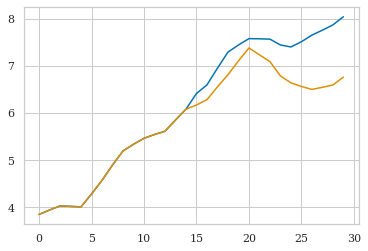

In [27]:
ii = 15
xxc = np.concatenate([X[:ii], X[ii+1:]])
yyc = X[ii]
means = xxc.mean(axis=0)*0
stds = xxc.std(axis=0)*0 + 1
xx = (xxc - means)/stds
yy = (yyc - means)/stds

xxp = xx.copy()
gp = GPR(kernels.RBF(0.1), n_restarts_optimizer=10, alpha=0.01).fit(xxp[:, :T0], xxp[:, T0:])
print(gp.kernel_)
yp = np.squeeze(gp.predict(yy[:T0].reshape(1, -1)))
ysample = np.squeeze(gp.sample_y(yy[:T0].reshape(1, -1), 100))        
yp = np.append(yyc[:T0], yp*stds[T0:] + means[T0:])
ysample = np.squeeze(gp.sample_y(yy[:T0].reshape(1, -1), 100))        
ysample = ysample.T*stds[T0:]
err = np.append(np.zeros(T0), ysample.std(axis=0))

plt.plot(yp)
# plt.plot(means)
plt.plot(yyc)

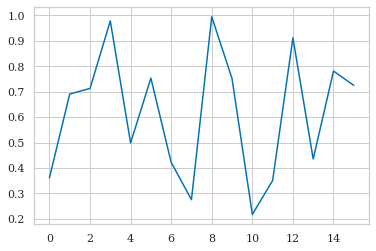

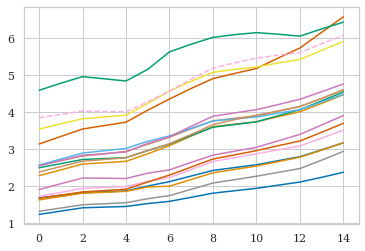

In [28]:
wts = gp.kernel_(gp.X_train_, yy[:T0].reshape(1, -1)).flatten()
plt.plot(wts)
plt.show()
wtspos = np.where(wts > 0.1)[0]
plt.plot(gp.X_train_[wtspos].T)
plt.plot(yy[:T0], '--')

In [29]:

    
statesgp, statesgppca, statesgppca3  =  {}, {}, {}
# for ss in ['CA']:
for ii, ss in enumerate(np.arange(N)):
    xxc = np.concatenate([X[:ii], X[ii+1:]])
    yyc = X[ii]
    means = xxc.mean(axis=0)
    stds = xxc.std(axis=0)*1# + 1
    xx = (xxc - means)/stds
    yy = (yyc - means)/stds

    xxp = xx.copy()
    gp = GPR(kernels.RBF(0.1), n_restarts_optimizer=20, alpha=0.1).fit(xxp[:, :T0], xxp[:, T0:])
    yp = np.squeeze(gp.predict(yy[:T0].reshape(1, -1)))
    ysample = np.squeeze(gp.sample_y(yy[:T0].reshape(1, -1), 100))        
    yp = np.append(yyc[:T0], yp*stds[T0:] + means[T0:])
    ysample = np.squeeze(gp.sample_y(yy[:T0].reshape(1, -1), 100))        
    ysample = ysample.T*stds[T0:]
    err = np.append(np.zeros(T0), ysample.std(axis=0))
    statesgp[ss] = GetObject(controls=xxc, treated=yyc, gp=gp, pred=yp, err=err)
    
    nc = tools.approximate_rank(xx-xx.mean(axis=0))
    pca =  PCA(nc).fit(xx)
    xxp = pca.inverse_transform(pca.transform(xx))
    alpha = (xx-xxp).std(axis=1)
    gp = GPR(kernels.RBF(0.1), n_restarts_optimizer=20, alpha=alpha).fit(xxp[:, :T0], xxp[:, T0:])
    yp = np.squeeze(gp.predict(yy[:T0].reshape(1, -1)))
    yp = np.append(yyc[:T0], yp*stds[T0:] + means[T0:])
    ysample = np.squeeze(gp.sample_y(yy[:T0].reshape(1, -1), 100))        
    ysample = ysample.T*stds[T0:]
    err = np.append(np.zeros(T0), ysample.std(axis=0))
    statesgppca[ss] = GetObject(controls=xxc, treated=yyc, gp=gp, pred=yp, err=err, pca=pca)

    
    nc = 3
    pca =  PCA(nc).fit(xx)
    xxp = pca.inverse_transform(pca.transform(xx))
    alpha = (xx-xxp).std(axis=1)
    gp = GPR(kernels.RBF(0.1), n_restarts_optimizer=20, alpha=alpha).fit(xxp[:, :T0], xxp[:, T0:])
    yp = np.squeeze(gp.predict(yy[:T0].reshape(1, -1)))
    yp = np.append(yyc[:T0], yp*stds[T0:] + means[T0:])
    ysample = np.squeeze(gp.sample_y(yy[:T0].reshape(1, -1), 100))        
    ysample = ysample.T*stds[T0:]
    err = np.append(np.zeros(T0), ysample.std(axis=0))
    statesgppca3[ss] = GetObject(controls=xxc, treated=yyc, gp=gp, pred=yp, err=err, pca=pca)

    
    


### plot

In [30]:
itreated = 15

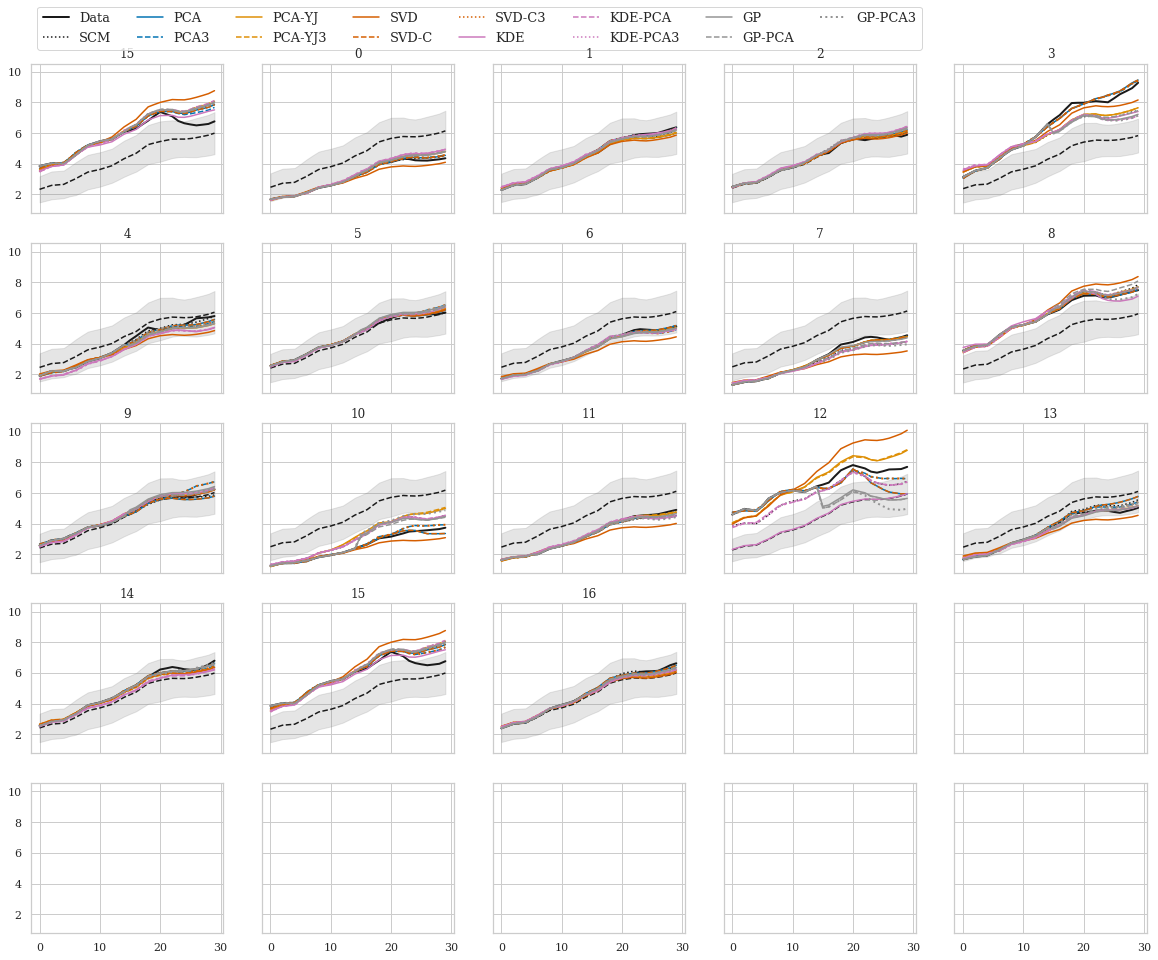

In [31]:
# irs = np.sort(np.random.permutation(np.arange(len(controlstates)))[:19])
nrow =  5
ncol = 5
irs = np.sort(np.random.permutation(np.arange(N))[:nrow*ncol-1])
fig, axar = plt.subplots(nrow, ncol, figsize=(ncol*4, nrow*3.2),
                         sharex=True, sharey=True)
ax = axar.flatten()

for jj, ss in enumerate(irs):
    ii = jj + 1
    xx = statepcafits[ss].controls
    means, stds = xx.mean(axis=0), xx.std(axis=0)
    yy = statepcafits[ss].treated
    
    ax[ii].plot(years, means, 'k--')
    ax[ii].fill_between(years, means-stds, means+stds, color='gray', alpha=0.2)
#     ax[ii].plot(years, statesales[ss], 'r--', lw=3, alpha=0.8)
    ax[ii].plot(years, yy, 'k', lw=2)
    
    ax[ii].plot(years, statesscm[ss].pred, 'k:')
    ax[ii].plot(years, statepcafits[ss].pred, 'C0-')
    ax[ii].plot(years, statepcafits3[ss].pred, 'C0--')
    ax[ii].plot(years, statepcafitsyj[ss].pred, 'C1-')
    ax[ii].plot(years, statepcafitsyj3[ss].pred, 'C1--')
    
    ax[ii].plot(years, statesvdfits[ss].pred, 'C3-')
    ax[ii].plot(years, statesvdfitsc[ss].pred, 'C3--')
    ax[ii].plot(years, statesvdfitsc3[ss].pred, 'C3:', lw=2)
    
    ax[ii].plot(years, stateskde[ss].pred, 'C4-')
    ax[ii].plot(years, stateskdepca[ss].pred, 'C4--')
    ax[ii].plot(years, stateskdepca3[ss].pred, 'C4:', lw=2)

    ax[ii].plot(years, statesgp[ss].pred, 'C7-')
    ax[ii].plot(years, statesgppca[ss].pred, 'C7--')
    ax[ii].plot(years, statesgppca3[ss].pred, 'C7:', lw=2)
    ax[ii].set_title(ss, fontsize=12)
    
ss = itreated
ii=0
xx = statepcafits[ss].controls
means, stds = xx.mean(axis=0), xx.std(axis=0)
yy = statepcafits[ss].treated
yp = synth.fit(xx, yy, T0)[0]

ax[ii].plot(years, means, 'k--')
ax[ii].fill_between(years, means-stds, means+stds, color='gray', alpha=0.2)
ax[ii].plot(years, yy, 'k', label='Data', lw=2)

ax[ii].plot(years, statesscm[ss].pred, 'k:', label='SCM')
ax[ii].plot(years, statepcafits[ss].pred, 'C0-', label='PCA')
ax[ii].plot(years, statepcafits3[ss].pred, 'C0--', label='PCA3')
ax[ii].plot(years, statepcafitsyj[ss].pred, 'C1-', label='PCA-YJ')
ax[ii].plot(years, statepcafitsyj3[ss].pred, 'C1--', label='PCA-YJ3')
ax[ii].plot(years, statesvdfits[ss].pred, 'C3-', label='SVD')
ax[ii].plot(years, statesvdfitsc[ss].pred, 'C3--', label='SVD-C')
ax[ii].plot(years, statesvdfitsc[ss].pred, 'C3:', label='SVD-C3')
ax[ii].plot(years, stateskde[ss].pred, 'C4-', label='KDE')
ax[ii].plot(years, stateskdepca[ss].pred, 'C4--', label='KDE-PCA')
ax[ii].plot(years, stateskdepca3[ss].pred, 'C4:', label='KDE-PCA3')
ax[ii].plot(years, statesgp[ss].pred, 'C7-', label='GP')
ax[ii].plot(years, statesgppca[ss].pred, 'C7--', label='GP-PCA')
ax[ii].plot(years, statesgppca3[ss].pred, 'C7:', label='GP-PCA3', lw=2)
ax[ii].set_title(ss, fontsize=12)
ax[ii].legend(ncol=8, fontsize=13, loc=3, bbox_to_anchor=(0, 1.05))

# for axis in ax:
# #     axis.set_xlim(1969, 2005)
#     axis.set_ylim(-100, 100)
#     axis.axvline(1988, color='c', ls='--')
#     ax[0].legend(ncol=6, bbox_to_anchor=(4.5, 1.3), fontsize=12)

15 -0.10967531579795552


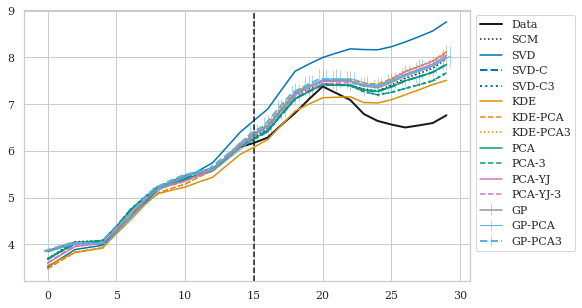

In [32]:
# for ss in statesid:
for ss in [itreated]:
    w1, w2 = stateskde[ss].wts.flatten(), statesscm[ss].wts.flatten()
    w1 /= w1.sum()
    w2 /= w2.sum()
    w1[w1<0.01] = 0
    w2[w2<0.01] = 0
    print(ss, np.corrcoef(w1, w2)[0, 1])
    
    fig, ax = plt.subplots(1,1, figsize=(8, 5))
    ax = [ax]
    ii=0
    ax[ii].plot(years, statesscm[ss].treated, 'k',lw=2, label='Data')

    ax[ii].plot(years, statesscm[ss].pred, 'k:', label='SCM')

    ax[ii].plot(years, statesvdfits[ss].pred, 'C0-', label='SVD')
    ax[ii].plot(years, statesvdfitsc[ss].pred, 'C0--', lw=2, label='SVD-C')
    ax[ii].plot(years, statesvdfitsc3[ss].pred, 'C0:', lw=2, label='SVD-C3')

    ax[ii].plot(years, stateskde[ss].pred, 'C1-', label='KDE')
    ax[ii].plot(years, stateskdepca[ss].pred, 'C1--', label='KDE-PCA')
    ax[ii].plot(years, stateskdepca3[ss].pred, 'C1:', label='KDE-PCA3')
    

    ax[ii].plot(years, statepcafits[ss].pred, 'C2', label='PCA')
    ax[ii].plot(years, statepcafits3[ss].pred, 'C2--', label='PCA-3')
    ax[ii].plot(years, statepcafitsyj[ss].pred, 'C4', label='PCA-YJ')
    ax[ii].plot(years, statepcafitsyj3[ss].pred, 'C4--', label='PCA-YJ-3')
    
    ax[ii].errorbar(years, statesgp[ss].pred, statesgp[ss].err, color='C7', label='GP', elinewidth=0.5)
    
    ax[ii].errorbar(years+0.25, statesgppca[ss].pred, statesgppca[ss].err, color='C9', ls="-", lw=1, elinewidth=0.5, label='GP-PCA')
    ax[ii].errorbar(years-0.25, statesgppca3[ss].pred, statesgppca3[ss].err, color='C9', ls="--",  lw=2, elinewidth=0.5, label='GP-PCA3')

plt.legend(loc=2, bbox_to_anchor=(1, 1))
plt.axvline(T0, color='k', ls="--")
# plt.xlim(1970, 2005)
# plt.ylim(0, 200)

In [33]:
diffscm  = np.zeros_like(controls)
diffsvd, diffsvdc, diffsvdc3  = np.zeros_like(controls), np.zeros_like(controls), np.zeros_like(controls)
diffkde, diffkdepca, diffkdepca3 = np.zeros_like(controls), np.zeros_like(controls), np.zeros_like(controls)
diffpca, diffpca3, diffpcayj, diffpcayj3 = np.zeros_like(controls), np.zeros_like(controls), np.zeros_like(controls), np.zeros_like(controls)
diffgp, diffgppca, diffgppca3 = np.zeros_like(controls), np.zeros_like(controls), np.zeros_like(controls)

for ii, ss in enumerate(np.arange(N-1)):
    if ii == itreated: continue
    xx = statepcafits[ss].controls
    means, stds = xx.mean(axis=0), xx.std(axis=0)
    yy = statepcafits[ss].treated

    diffscm[ii] = (yy-statesscm[ss].pred)

    diffpca[ii] = (yy-statepcafits[ss].pred)
    diffpcayj[ii] = (yy-statepcafitsyj[ss].pred)    
    diffpca3[ii] = (yy-statepcafits3[ss].pred)
    diffpcayj3[ii] = (yy-statepcafitsyj3[ss].pred)
    
    diffsvd[ii] = (yy-statesvdfits[ss].pred)
    diffsvdc[ii] = (yy-statesvdfitsc[ss].pred)
    diffsvdc3[ii] = (yy-statesvdfitsc3[ss].pred)
    
    diffkde[ii] = (yy-stateskde[ss].pred)
    diffkdepca[ii] = (yy-stateskdepca[ss].pred)
    diffkdepca3[ii] = (yy-stateskdepca3[ss].pred)
    
    diffgp[ii] = (yy-statesgp[ss].pred)
    diffgppca[ii] = (yy-statesgppca[ss].pred)
    diffgppca3[ii] = (yy-statesgppca3[ss].pred)


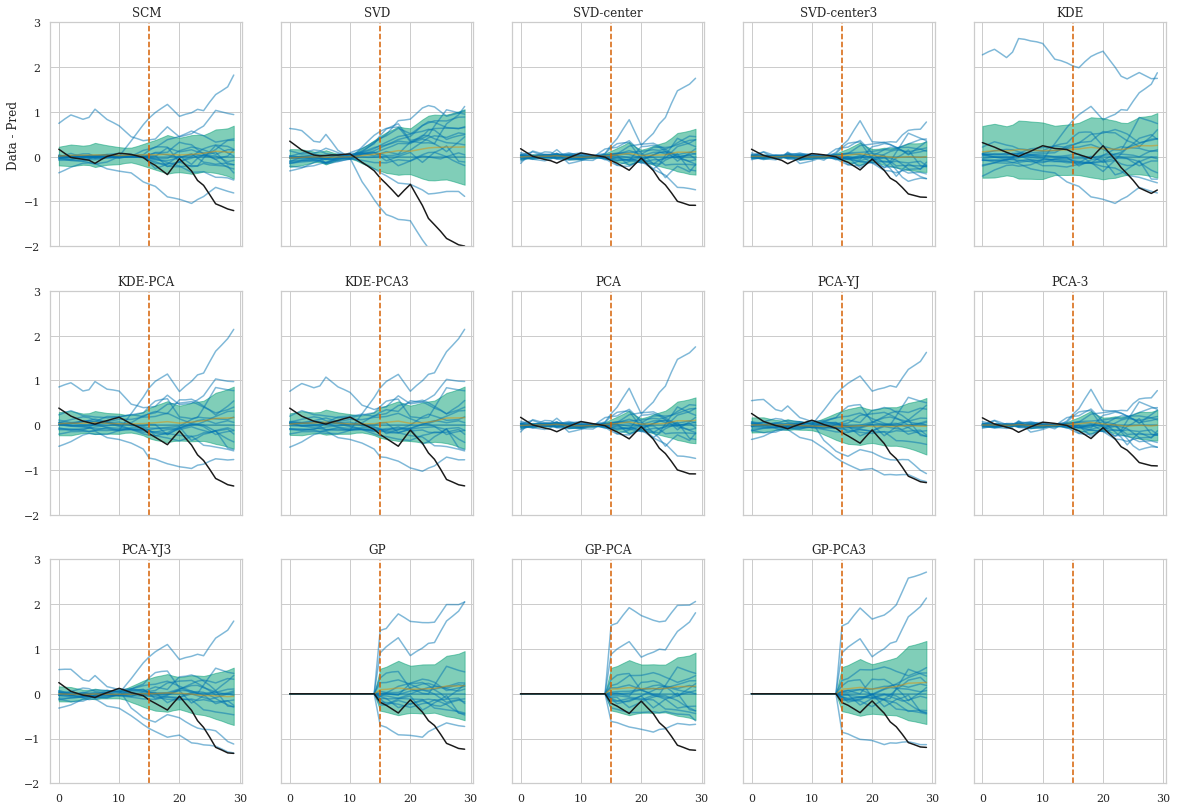

In [34]:



tmpy = statepcafits[itreated].treated

fig, axar = plt.subplots(3, 5, figsize=(20, 14), sharex=True, sharey=True)
ax = axar.flatten()

dd = diffscm.copy()
ax[0].plot(years, dd.T, 'C0-', alpha=0.5)
ax[0].plot(years, dd.mean(axis=0), 'C1', alpha=0.5)
ax[0].fill_between(years, dd.mean(axis=0) - dd.std(axis=0), dd.mean(axis=0) + dd.std(axis=0), color='C2', alpha=0.5)
ax[0].plot(years, tmpy - statesscm[itreated].pred, 'k-', alpha=1)
ax[0].set_title('SCM')
ax[0].set_ylabel("Data - Pred")


def tmpplot(ii, title, dd, ddca):
    ax[ii].plot(years, dd.T, 'C0-', alpha=0.5)
    ax[ii].plot(years, dd.mean(axis=0), 'C1', alpha=0.5)
    ax[ii].fill_between(years, dd.mean(axis=0) - dd.std(axis=0), dd.mean(axis=0) + dd.std(axis=0), color='C2', alpha=0.5)
    ax[ii].plot(years, tmpy - ddca, 'k-', alpha=1)
    ax[ii].set_title(title)

ii, title, dd, ddca = 1, 'SVD', diffsvd.copy(), statesvdfits[itreated].pred
tmpplot(ii, title, dd, ddca)

ii, title, dd, ddca = 2, 'SVD-center', diffsvdc.copy(), statesvdfitsc[itreated].pred
tmpplot(ii, title, dd, ddca)

ii, title, dd, ddca = 3, 'SVD-center3', diffsvdc3.copy(), statesvdfitsc3[itreated].pred
tmpplot(ii, title, dd, ddca)

ii, title, dd, ddca = 4, 'KDE', diffkde.copy(), stateskde[itreated].pred
tmpplot(ii, title, dd, ddca)

ii, title, dd, ddca = 5, 'KDE-PCA', diffkdepca.copy(), stateskdepca[itreated].pred
tmpplot(ii, title, dd, ddca)

ii, title, dd, ddca = 6, 'KDE-PCA3', diffkdepca3.copy(), stateskdepca3[itreated].pred
tmpplot(ii, title, dd, ddca)

ii, title, dd, ddca = 7, 'PCA', diffpca.copy(), statepcafits[itreated].pred
tmpplot(ii, title, dd, ddca)

ii, title, dd, ddca = 8, 'PCA-YJ', diffpcayj.copy(), statepcafitsyj[itreated].pred
tmpplot(ii, title, dd, ddca)

ii, title, dd, ddca = 9, 'PCA-3', diffpca3.copy(), statepcafits3[itreated].pred
tmpplot(ii, title, dd, ddca)

ii, title, dd, ddca = 10, 'PCA-YJ3', diffpcayj3.copy(), statepcafitsyj3[itreated].pred
tmpplot(ii, title, dd, ddca)

ii, title, dd, ddca = 11, 'GP', diffgp.copy(), statesgp[itreated].pred
tmpplot(ii, title, dd, ddca)

ii, title, dd, ddca = 12, 'GP-PCA', diffgppca.copy(), statesgppca[itreated].pred
tmpplot(ii, title, dd, ddca)

ii, title, dd, ddca = 13, 'GP-PCA3', diffgppca3.copy(), statesgppca3[itreated].pred
tmpplot(ii, title, dd, ddca)

for axis in ax:
#     axis.set_xlim(1969, 2005)
    axis.set_ylim(-2, 3)
    axis.axvline(T0, color='r', ls='--')


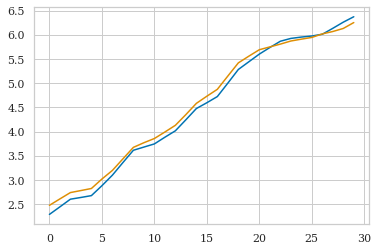

In [35]:
plt.plot(stateskde[1].treated)
plt.plot(stateskde[1].pred)